# XRISM orbit

1. Orbit on world map.
2. Distance from USC.
3. Elevation seen from USC.
4. Changes or RAAN, solar pos, beta angle
   
Use toppy:/usr/bin/python3.10 for execution.

In [1]:
########################################################
# Imports
########################################################
import sys
sys.path.append('/home/tsujimot/bin/')
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import datetime
#
import astropy
from astropy.io import fits
import astropy.time
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astropy import units as u
#
import skyfield.api
from skyfield.api import load, wgs84
import sgp4.ext
import ephem
#
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
palette_rainbow=sns.color_palette("hls",16)
palette=('grey','red','blue','green','purple','orange', 'magenta','cyan','yellow','brown','violet','turquoise')

from resolve_ope_GVO import eq2ecl, ecl2eq, radec2vec, vec2radec, get_v3, solar_lonlat_calc, beta_angle, get_sat_radec

# Constants
TIMESCALE: skyfield.api.Timescale = skyfield.api.load.timescale()
MU: np.float64 = np.float64(3.986004418)

# JPL Almanac
eph = load('de421.bsp')
print('Ready')

########################################################
# User-defined parameters
########################################################
# Constants
TIMESCALE: skyfield.api.Timescale = skyfield.api.load.timescale()
MU: np.float64 = np.float64(3.986004418)
ECLIPTIC_OBIQUITY: np.double = np.double(23.45) # Degrees
# Frame
frame_ecl = astropy.coordinates.GeocentricTrueEcliptic()
frame_eq = astropy.coordinates.TETE()

# XRISM
satellite_name = 'XRISM'
sun_angle_max=20.0

# Ground stations
stations={
    'USC' : [31.25, 131.8, 0],
    'KTU' : [35.2, 140.3, 0],
    'SNT' : [-33.13, -70.67, 1],
    'MSP' : [27.72, -15.63, 1],
    'MGN' : [-29.194, 115.441, 1],
    'HBK' : [-25.8872, 27.7075, 2],
    'USHI' : [20.706, -156.257, 2],
}

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Ready


In [463]:
# Get XRISM orbital elements
brightest_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=visual&FORMAT=tle'
satellites = skyfield.api.load.tle_file(brightest_url)
satellites_by_name = {sat.name: sat for sat in satellites}
satellite = satellites_by_name[satellite_name]

# Time span.
def get_span(datetime_start, datetime_end, tstep):
    span = [datetime_start]
    while span[-1] < datetime_end:
        span.append(span[-1] + datetime.timedelta(seconds=tstep))
    return span

## Orbit on world map.

In [464]:
datetime_start=datetime.datetime(2023,12,1,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2023,12,2,0,0,0, tzinfo=datetime.timezone.utc)
tstep=10
span=get_span(datetime_start, datetime_end, tstep)

geocentric = [satellite.at(TIMESCALE.utc(_span)) for _span in span]
lat = np.array([wgs84.latlon_of(_geocentric)[0].degrees for _geocentric in geocentric])
lon = np.array([wgs84.latlon_of(_geocentric)[1].degrees for _geocentric in geocentric])
colors=[palette_rainbow[int((15.0*i)//len(lat))] for i in range(len(lat))]

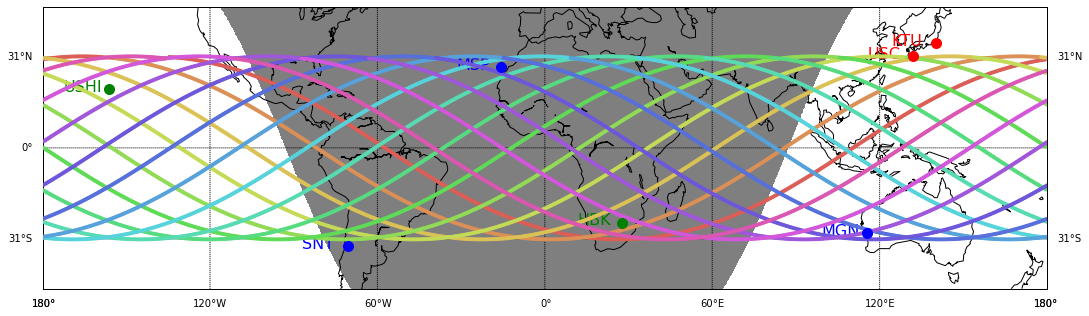

In [465]:
plt.figure(figsize=(18,12))
map = Basemap(projection='merc', llcrnrlon=-180, urcrnrlon=180, llcrnrlat=-45, urcrnrlat=45)
map.drawcoastlines()
map.drawparallels([-31,31],labels=[1,1])
map.drawparallels([0],labels=[1])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
map.drawmapboundary(fill_color='none')
map.fillcontinents(color='none',lake_color='none')

# Day/Night
date = span[0] #datetime(2023,12,1,0,0,0)
CS=map.nightshade(date)

# Orbits
lonlat_proj = np.array([map(_lon, _lat) for _lon, _lat in zip(lon, lat)])
map.scatter(lonlat_proj[:,0], lonlat_proj[:,1], marker = '.', color=colors, zorder=5)

# Ground stations
for key in stations.keys():
    slat, slon, color = stations[key]
    slon_proj, slat_proj = map(slon, slat)
    map.scatter(slon_proj, slat_proj, marker = 'o', color=palette[color+1], s=100, zorder=10)
    plt.text(slon_proj-1800000,slat_proj-100000,'{}'.format(key), fontsize=16, color=palette[color+1])

plt.savefig('./lonlat.pdf')
plt.show()

## Distance from USC

In [466]:
# Fixed position on Earth
station="USC"
SomewhereOnEarth = wgs84.latlon(stations[station][0], stations[station][1])
topocentric = [(satellite - SomewhereOnEarth).at(TIMESCALE.utc(_span)) for _span in span]
alt = [_topocentric.altaz()[0].to(u.deg).value for _topocentric in topocentric]
az = [_topocentric.altaz()[1].to(u.deg).value for _topocentric in topocentric]
dist = [_topocentric.altaz()[2].to(u.km).value for _topocentric in topocentric]
#ra = [_topocentric.radec()[0].to(u.deg).value for _topocentric in topocentric]
#dec = [_topocentric.radec()[1].to(u.deg).value for _topocentric in topocentric]
#dist = [_topocentric.radec()[2].to(u.km).value for _topocentric in topocentric]

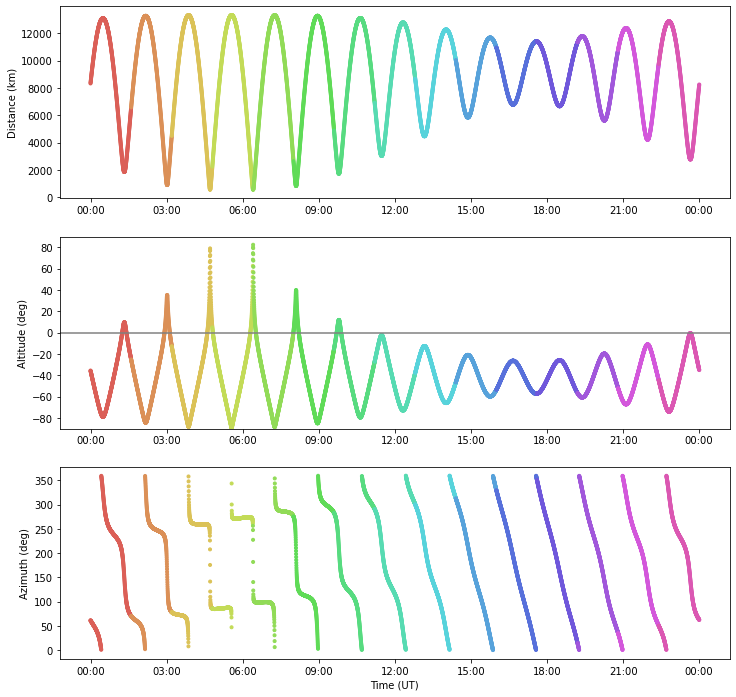

In [467]:
from matplotlib import dates as mdates

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(311)
ax1.scatter(span, dist, marker='.', color=colors)
ax1.set_ylabel("Distance (km)")
ax2 = fig.add_subplot(312, sharex=ax1)
ax2.scatter(span, alt, marker='.', color=colors)
ax2.set_ylabel("Altitude (deg)")
ax2.set_ylim([-90,90])
ax2.axhline(0.0, color="grey") #, dashes="dash")
ax3 = fig.add_subplot(313, sharex=ax1)
ax3.scatter(span, az, marker='.', color=colors)
ax3.set_xlabel("Time (UT)")
ax3.set_ylabel("Azimuth (deg)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig('./dist.pdf')
plt.show()

## Altitude and azimuth from USC

In [468]:
altaz=pd.DataFrame([alt,az,colors]).T
altaz.columns=["Alt", "Az", "Color"]
altaz_RoI=altaz[altaz.Alt>0.0].copy()
altaz_RoI["Az_rad"] = altaz_RoI["Az"].apply(lambda x: np.deg2rad(x))
altaz_RoI["Alt_inv"] = altaz_RoI["Alt"].apply(lambda x: 90.0-x)

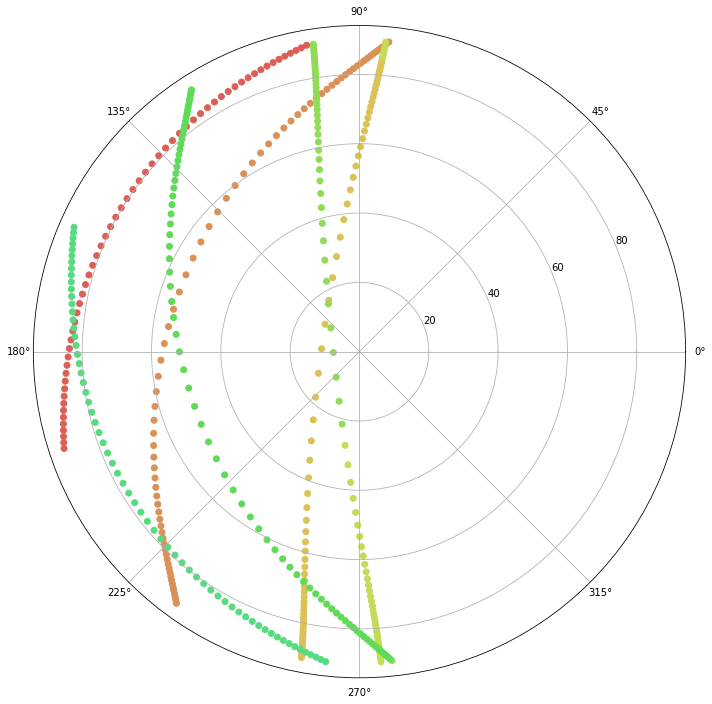

In [474]:
plt.figure(figsize=(18,12))
ax = plt.subplot(111, projection="polar")
ax.scatter(altaz_RoI["Az_rad"].values, 90.0-altaz_RoI["Alt"].values, color=altaz_RoI["Color"].values)
plt.savefig('./altaz.pdf')
plt.show()

## Orbital element changes

In [470]:
datetime_start=datetime.datetime(2024,1,1,0,0,0, tzinfo=datetime.timezone.utc)
datetime_end=datetime.datetime(2024,12,31,0,0, tzinfo=datetime.timezone.utc)
tstep=3600*24
span=get_span(datetime_start, datetime_end, tstep)

In [471]:
# Orbital element
elements = [sgp4.ext.rv2coe(p.position.km, p.velocity.km_per_s, MU) for p in [satellite.at(TIMESCALE.from_datetime(t)) for t in span]]
inclination: np.ndarray = np.asarray([np.rad2deg(e[3]) for e in elements], dtype=float)
raan: np.ndarray = np.asarray([np.rad2deg(e[4]) for e in elements], dtype=float)

# Solar position
sun = eph["Sun"]
earth = eph["Earth"]
#sun_pos = [(earth + SomewhereOnEarth).at(TIMESCALE.utc(_span)).observe(sun) for _span in span]
sun_pos = [earth.at(TIMESCALE.utc(_span)).observe(sun).apparent() for _span in span]
sun_ra = np.array([_sun_pos.radec()[0].to(u.deg).value for _sun_pos in sun_pos])
sun_dec = np.array([_sun_pos.radec()[1].to(u.deg).value for _sun_pos in sun_pos])
from skyfield.framelib import ecliptic_frame
sun_lat = np.array([_sun_pos.frame_latlon(ecliptic_frame)[0].to(u.deg).value for _sun_pos in sun_pos])
sun_lon = np.array([_sun_pos.frame_latlon(ecliptic_frame)[1].to(u.deg).value for _sun_pos in sun_pos])

# Beta angle
beta = beta_angle(sun_lon, inclination, raan)

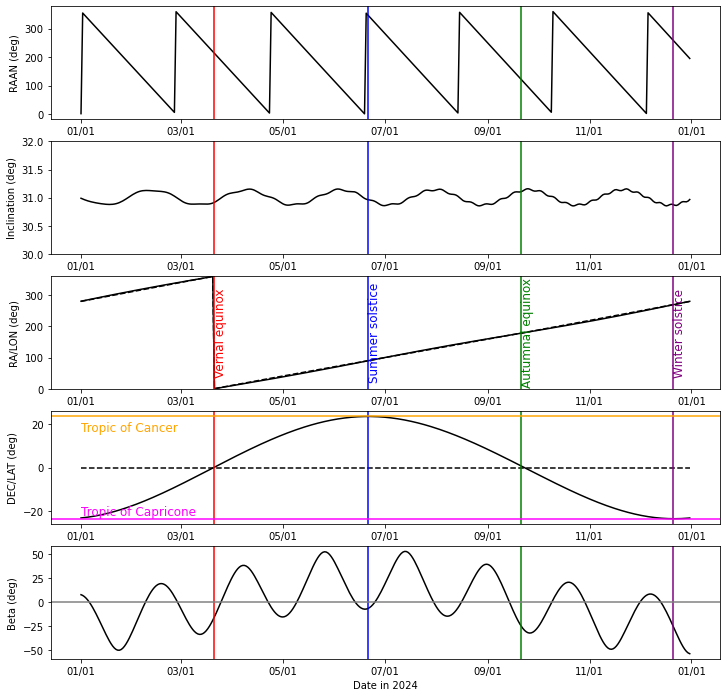

In [472]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(511)
ax1.plot(span, raan, color="black")
ax1.set_ylabel("RAAN (deg)")
ax2 = fig.add_subplot(512, sharex=ax1)
ax2.plot(span, inclination, color="black")
ax2.set_ylabel("Inclination (deg)")
ax2.set_ylim([30,32])
ax3 = fig.add_subplot(513, sharex=ax1)
ax3.plot(span, sun_ra, color="black")
ax3.plot(span, sun_lon, color="black", ls="--")
ax3.set_ylabel("RA/LON (deg)")
ax3.set_ylim([0,360])
ax4 = fig.add_subplot(514, sharex=ax1)
ax4.plot(span, sun_dec, color="black")
ax4.plot(span, sun_lat, color="black", ls="--")
ax4.set_ylabel("DEC/LAT (deg)")
ax5 = fig.add_subplot(515, sharex=ax1)
ax5.plot(span, beta, color="black")
ax5.set_ylabel("Beta (deg)")
ax5.set_xlabel("Date in 2024")
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.axvline(datetime.datetime(2024,3,21), color=palette[1])
    ax.axvline(datetime.datetime(2024,9,21), color=palette[3])
    ax.axvline(datetime.datetime(2024,6,21), color=palette[2])
    ax.axvline(datetime.datetime(2024,12,21), color=palette[4])

ax=ax3
ax.text(datetime.datetime(2024,3,21), 180, "Vernal equinox", rotation=90, fontsize=12, color=palette[1], verticalalignment='center')
ax.text(datetime.datetime(2024,9,21), 180, "Autumnal equinox", rotation=90, fontsize=12, color=palette[3], verticalalignment='center')
ax.text(datetime.datetime(2024,6,21), 180, "Summer solstice", rotation=90, fontsize=12, color=palette[2], verticalalignment='center')
ax.text(datetime.datetime(2024,12,21), 180, "Winter solstice", rotation=90, fontsize=12, color=palette[4], verticalalignment='center')

ax4.axhline(ECLIPTIC_OBIQUITY, color=palette[5])
ax4.axhline(-ECLIPTIC_OBIQUITY, color=palette[6])
ax4.text(datetime.datetime(2024,1,1,0,0,0), ECLIPTIC_OBIQUITY-5.0, "Tropic of Cancer", fontsize=12, color=palette[5], verticalalignment='center')
ax4.text(datetime.datetime(2024,1,1,0,0,0), -ECLIPTIC_OBIQUITY+3.0, "Tropic of Capricone", fontsize=12, color=palette[6], verticalalignment='center')

ax5.axhline(0, color="grey", ls="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.savefig('./orb_elem.pdf')
plt.show()